# Coursework

COMPLETED: custom dataset, dataload, implement CNN, cross validation

TODO: balance the dataset, hyperparameter optimization

In [260]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
# import cv2
import seaborn as sns
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils

# explore the label info

<AxesSubplot:xlabel='Type', ylabel='count'>

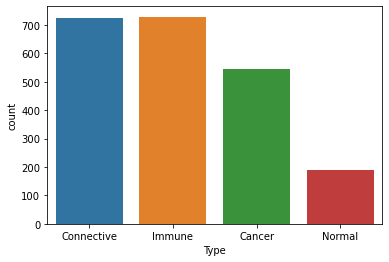

In [67]:
# plot the distribution of training data

train = pd.read_csv('data/train.csv')
sns.countplot(x='Type', data=train)

# Modify label info

In [141]:
label_map = {'Connective': 0,
             'Immune': 1,
             'Cancer': 2,
             'Normal': 3}

In [150]:
label_map

{'Connective': 0, 'Immune': 1, 'Cancer': 2, 'Normal': 3}

# Create custom dataset

In [303]:
class ImageDataset(Dataset):
    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])+'.png')
        image = read_image(img_path) / 255
        label = label_map.get(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
#         sample = {"image": image, "label": label}
        sample = (image, label)
        return sample

In [304]:
train_dataset = ImageDataset(labels_file='data/train.csv', img_dir='data/train/train/')
test_dataset = ImageDataset(labels_file='data/example.csv', img_dir='data/test/test/')
# train_dataset[11]

In [219]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset)

# Check images and labels

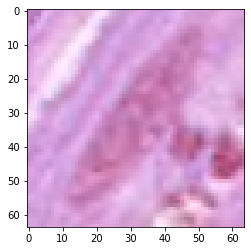

In [250]:
# check test data

# test_features = next(iter(test_dataloader))['image']
test_features, test_labels = next(iter(test_dataloader))
grid = utils.make_grid(test_features[0])
plt.imshow(grid.numpy().transpose((1, 2, 0)))
# print(test_features)

Feature batch shape: torch.Size([32, 3, 64, 64])
Labels batch shape: torch.Size([32])


Text(0.5, 1.0, 'tensor([0, 3, 1, 3, 0, 2, 0, 0, 2, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 1,\n        1, 1, 0, 0, 0, 2, 0, 2])')

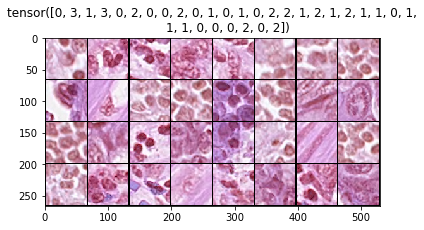

In [221]:
# check train images and labels
# train_features = next(iter(train_dataloader))['image']
# train_labels = next(iter(train_dataloader))['label']
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
grid = utils.make_grid(train_features)
plt.imshow(grid.numpy().transpose((1, 2, 0)), interpolation='nearest')
plt.title(train_labels)

# Model

In [320]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections

use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# CPU is used in my case

# model = nn.Sequential(collections.OrderedDict([
#           ('conv1', nn.Conv2d(3,32,3)),
#           ('relu1', nn.ReLU()),
#           ('conv2', nn.Conv2d(32,16,3)),
#           ('relu2', nn.ReLU()),
#           ('pool', nn.MaxPool2d(2)),
#           ('flatten', nn.Flatten()),
#           ('dense1', nn.Linear(14400,1000)),
#           ('relu3', nn.ReLU()),
#           ('dense2', nn.Linear(1000,100)),
#           ('relu4', nn.ReLU()),
#           ('dense3', nn.Linear(100,4)),
# # If you are using CrossEntropyLoss then the output of your neural network should be a linear output layer 
# #     (rather than a softmax output layer). 
# #     This is because CrossEntropyLoss combines LogSoftmax and NLLLoss into a single class.
#           ('softmax', nn.Softmax(1))
#         ]))
model = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv2d(3,32,3)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(32,16,3)),
          ('relu2', nn.ReLU()),
          ('pool1', nn.MaxPool2d(2)),
          ('conv3', nn.Conv2d(16,8,3)),
          ('relu3', nn.ReLU()),
          ('pool2', nn.MaxPool2d(2)),
          ('flatten', nn.Flatten()),
          ('dense1', nn.Linear(1568,100)),
          ('relu3', nn.ReLU()),
          ('dense2', nn.Linear(100,4)),
        ]))

In [315]:
print(model)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=1568, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=4, bias=True)
)


In [312]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))


In [316]:
# set learning rate, optimizer and loss function
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# set the number of epochs
n_epochs = 1

# train the CNN
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)


2021-05-23 22:12:29.859259 Epoch 1, Training loss 90.3878870010376


# Make predictions

In [328]:
# test_loop(model = model, device = device, test_loader = test_dataloader)
for data, target in test_dataloader:
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)
#     pred = pred.numpy()
    print(pred)

tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[3]])
tensor([[0]])
tensor([[3]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[3]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[2]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor

# Try cross validation

In [326]:
from sklearn.model_selection import KFold

torch.manual_seed(24)
k_fold = 5
kfold = KFold(n_splits=k_fold, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(kfold.split(train_dataset)):
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)

#     # define data loaders for training and testing data in this fold
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    test_loader = DataLoader(train_dataset, batch_size=32, sampler=test_subsampler)
#     train_fold = train_dataset[train_idx]
#     test_fold = train_dataset[test_idx]

#     train_loader = DataLoader(train_fold, batch_size = 32, shuffle = True)
#     test_loader = DataLoader(test_fold, batch_size = 32, shuffle = False)

    # set learning rate, optimizer and loss function
    lr = 0.01
    optimizer = optim.SGD(model.parameters(), lr=lr)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # set the number of epochs
    n_epochs = 5

    # train the CNN
    training_loop(
        n_epochs = n_epochs, 
        optimizer = optimizer,
        model = model, 
        device = device,
        loss_fn = loss_fn,
        train_loader = train_loader,
    )
    test_loop(model = model, device = device, test_loader = test_loader)


2021-05-23 22:39:41.818551 Epoch 1, Training loss 35.96566188335419
2021-05-23 22:39:50.190313 Epoch 2, Training loss 36.99218975007534
2021-05-23 22:39:58.514821 Epoch 3, Training loss 35.57063667476177
2021-05-23 22:40:06.832160 Epoch 4, Training loss 35.93714877963066
2021-05-23 22:40:15.184517 Epoch 5, Training loss 35.367747247219086

Test set: Average loss: -2.7610, Accuracy: 325/438 (74%)

2021-05-23 22:40:24.568977 Epoch 1, Training loss 37.23173040151596
2021-05-23 22:40:32.889729 Epoch 2, Training loss 35.77387398481369
2021-05-23 22:40:41.170270 Epoch 3, Training loss 34.7177392244339
2021-05-23 22:40:49.479242 Epoch 4, Training loss 33.477929532527924
2021-05-23 22:40:57.814273 Epoch 5, Training loss 33.734457582235336

Test set: Average loss: -2.6187, Accuracy: 340/438 (78%)

2021-05-23 22:41:07.290840 Epoch 1, Training loss 33.893933579325676
2021-05-23 22:41:15.657316 Epoch 2, Training loss 33.99021103978157
2021-05-23 22:41:23.978696 Epoch 3, Training loss 33.1328149437